In [56]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
# from tensorflow.keras import backend as K
from tensorflow import keras
import random
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow_model_optimization.sparsity import keras as sparsity
from keras.models import model_from_json
from tensorflow_model_optimization.sparsity.keras import Prune

ImportError: cannot import name 'Prune' from 'tensorflow_model_optimization.sparsity.keras' (C:\Users\Mahender\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_model_optimization\python\core\api\sparsity\keras\__init__.py)

In [2]:
# keras.mixed_precision.set_global_policy("mixed_float16")

In [3]:
project_path = r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\sem4\ADV topics in DS LLM\Project\Text-to-image-for-compression'

# # 10 images 0 to 9 - 1 each
# img_path = project_path + r'\\Data\Data-10-images'
# model_name = 'nn-10-0to9.h5'
# grayscale_path = img_path + '-gray'

# 10 images of 1
img_path = r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\sem4\ADV topics in DS LLM\Project\Text-to-image-for-compression\Data\Data-10-images-1'
model_name = 'nn-10-1.h5'
grayscale_path = img_path + '-gray'

# # All images of 1 - 10772 images
# img_path = r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\sem4\ADV topics in DS LLM\Project\Text-to-image-for-compression\Data\dataset\1\1'
# model_name = 'nn-all-1.h5'
# grayscale_path = img_path + '-gray'

# # All images 0 to 9 - 118503 images
# img_path = r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\sem4\ADV topics in DS LLM\Project\Text-to-image-for-compression\Data\Data-all-images'
# model_name = 'nn-all.h5'
# grayscale_path = img_path + '-gray'


model_save_path = r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\sem4\ADV topics in DS LLM\Project\Text-to-image-for-compression'

# Create the folder if it doesn't exist
if not os.path.exists(grayscale_path):
    os.makedirs(grayscale_path)

image_extension = '.png'

data = []

# Loop through all directories and subdirectories
for root, dirs, files in os.walk(img_path):
    for file in files:
        if file.lower().endswith(image_extension):
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                
                # If the image is in RGBA, convert transparent pixels to white
                if img.mode == 'RGBA':
                    white_bg = Image.new('RGB', img.size, (255, 255, 255))
                    white_bg.paste(img, mask=img.split()[3])
                    # Convert the image to grayscale (L mode)
                    img = white_bg.convert('L')
                else:
                    # If the image is already grayscale or RGB, just convert it to grayscale
                    img = img.convert('L')
                
                # Convert image to numpy array and save to DataFrame
                img_data = np.array(img)
                label = file_path.split('\\')[-1]
                data.append({"label": label, "image_data": img_data})

                # Save the converted grayscale image
                save_path = os.path.join(grayscale_path, file)
                img.save(save_path)

            except Exception as e:
                print(f"Error opening {file_path}: {e}")

# Create a DataFrame
df = pd.DataFrame(data)
print(df.head())

     label                                         image_data
0  100.png  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
1  101.png  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
2  102.png  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
3  103.png  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
4  104.png  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...


In [4]:
# Extract labels from the dataframe
labels = df['label'].values

# Convert the labels to one-hot encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)

# onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder = OneHotEncoder()
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# The onehot_encoded array will be used as input to the model

In [5]:
# Assuming all images are grayscale and of size
X = df['image_data'].values

# Normalize pixel values
X = np.array([x.flatten() / 255.0 for x in X])  # Flatten the images and normalize pixel values

In [36]:
# Define the model
def create_model(input_dim, output_dim):
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu', input_dim=input_dim))  # First dense layer
#     model.add(layers.Dense(512, activation='relu'))  # Hidden dense layer
#     model.add(layers.Dense(1024, activation='relu'))  # Hidden dense layer
    model.add(layers.Dense(32, activation='relu'))  # Hidden dense layer
#     model.add(layers.Dense(64, activation='relu'))  # Hidden dense layer

    model.add(layers.Dense(output_dim, activation='sigmoid'))  # Output layer (flattened image)
    return model

# Assume one-hot encoded labels have shape (num_samples, num_labels)
input_dim = onehot_encoded.shape[1]
output_dim = 28 * 28

model = create_model(input_dim, output_dim)

In [37]:
pruning_params = {
    'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.0,
                                                 final_sparsity=0.5,
                                                 begin_step=2000,
                                                 end_step=4000)
}
model = sparsity.prune_low_magnitude(model, **pruning_params)

In [38]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_dense_1  (None, 32)               674       
 2 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_1  (None, 32)               2082      
 3 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_1  (None, 784)              50962     
 4 (PruneLowMagnitude)                                           
                                                                 
Total params: 53,718
Trainable params: 27,280
Non-trainable params: 26,438
_________________________________________________________________


In [39]:
# Add the UpdatePruningStep callback and PruningSummaries callback
callbacks = [
    sparsity.UpdatePruningStep(),
    sparsity.PruningSummaries(log_dir='./logs')  # You can provide your log directory here
]

In [40]:
# Train the model
model.fit(onehot_encoded, X, epochs=1200, batch_size=64, callbacks=callbacks)

Epoch 1/1200
1/1 [==============================] - 1s 1s/step - loss: 0.2452 - accuracy: 0.0000e+00
Epoch 2/1200
1/1 [==============================] - 0s 7ms/step - loss: 0.2446 - accuracy: 0.0000e+00
Epoch 3/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.2439 - accuracy: 0.0000e+00
Epoch 4/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.2432 - accuracy: 0.0000e+00
Epoch 5/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.2425 - accuracy: 0.0000e+00
Epoch 6/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.2418 - accuracy: 0.0000e+00
Epoch 7/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.2410 - accuracy: 0.0000e+00
Epoch 8/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.2402 - accuracy: 0.0000e+00
Epoch 9/1200
1/1 [==============================] - 0s 9ms/step - loss: 0.2394 - accuracy: 0.0000e+00
Epoch 10/1200
1/1 [==============================] - 0s 9ms/step - loss: 0.2385 - a

1/1 [==============================] - 0s 8ms/step - loss: 0.0411 - accuracy: 0.0000e+00
Epoch 81/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0400 - accuracy: 0.0000e+00
Epoch 82/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0389 - accuracy: 0.0000e+00
Epoch 83/1200
1/1 [==============================] - 0s 7ms/step - loss: 0.0379 - accuracy: 0.0000e+00
Epoch 84/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0370 - accuracy: 0.0000e+00
Epoch 85/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0362 - accuracy: 0.0000e+00
Epoch 86/1200
1/1 [==============================] - 0s 9ms/step - loss: 0.0354 - accuracy: 0.0000e+00
Epoch 87/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0347 - accuracy: 0.0000e+00
Epoch 88/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0341 - accuracy: 0.0000e+00
Epoch 89/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0335 - accur

1/1 [==============================] - 0s 8ms/step - loss: 0.0232 - accuracy: 0.0000e+00
Epoch 160/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0231 - accuracy: 0.0000e+00
Epoch 161/1200
1/1 [==============================] - 0s 10ms/step - loss: 0.0230 - accuracy: 0.0000e+00
Epoch 162/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0229 - accuracy: 0.0000e+00
Epoch 163/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0228 - accuracy: 0.0000e+00
Epoch 164/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0228 - accuracy: 0.0000e+00
Epoch 165/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0227 - accuracy: 0.0000e+00
Epoch 166/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0226 - accuracy: 0.0000e+00
Epoch 167/1200
1/1 [==============================] - 0s 9ms/step - loss: 0.0225 - accuracy: 0.0000e+00
Epoch 168/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.02

1/1 [==============================] - 0s 8ms/step - loss: 0.0161 - accuracy: 0.0000e+00
Epoch 238/1200
1/1 [==============================] - 0s 7ms/step - loss: 0.0160 - accuracy: 0.0000e+00
Epoch 239/1200
1/1 [==============================] - 0s 7ms/step - loss: 0.0159 - accuracy: 0.0000e+00
Epoch 240/1200
1/1 [==============================] - 0s 7ms/step - loss: 0.0158 - accuracy: 0.0000e+00
Epoch 241/1200
1/1 [==============================] - 0s 7ms/step - loss: 0.0157 - accuracy: 0.0000e+00
Epoch 242/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0156 - accuracy: 0.0000e+00
Epoch 243/1200
1/1 [==============================] - 0s 7ms/step - loss: 0.0155 - accuracy: 0.0000e+00
Epoch 244/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0154 - accuracy: 0.0000e+00
Epoch 245/1200
1/1 [==============================] - 0s 7ms/step - loss: 0.0153 - accuracy: 0.0000e+00
Epoch 246/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.015

1/1 [==============================] - 0s 8ms/step - loss: 0.0097 - accuracy: 0.0000e+00
Epoch 316/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0097 - accuracy: 0.0000e+00
Epoch 317/1200
1/1 [==============================] - 0s 7ms/step - loss: 0.0096 - accuracy: 0.0000e+00
Epoch 318/1200
1/1 [==============================] - 0s 7ms/step - loss: 0.0095 - accuracy: 0.0000e+00
Epoch 319/1200
1/1 [==============================] - 0s 7ms/step - loss: 0.0095 - accuracy: 0.0000e+00
Epoch 320/1200
1/1 [==============================] - 0s 7ms/step - loss: 0.0094 - accuracy: 0.0000e+00
Epoch 321/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0093 - accuracy: 0.0000e+00
Epoch 322/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0092 - accuracy: 0.0000e+00
Epoch 323/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0092 - accuracy: 0.0000e+00
Epoch 324/1200
1/1 [==============================] - 0s 9ms/step - loss: 0.009

1/1 [==============================] - 0s 8ms/step - loss: 0.0051 - accuracy: 0.0000e+00
Epoch 394/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0051 - accuracy: 0.0000e+00
Epoch 395/1200
1/1 [==============================] - 0s 7ms/step - loss: 0.0050 - accuracy: 0.0000e+00
Epoch 396/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0050 - accuracy: 0.0000e+00
Epoch 397/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0049 - accuracy: 0.0000e+00
Epoch 398/1200
1/1 [==============================] - 0s 9ms/step - loss: 0.0049 - accuracy: 0.0000e+00
Epoch 399/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0048 - accuracy: 0.0000e+00
Epoch 400/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0048 - accuracy: 0.0000e+00
Epoch 401/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0047 - accuracy: 0.0000e+00
Epoch 402/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.004

1/1 [==============================] - 0s 8ms/step - loss: 0.0025 - accuracy: 0.0000e+00
Epoch 472/1200
1/1 [==============================] - 0s 7ms/step - loss: 0.0024 - accuracy: 0.0000e+00
Epoch 473/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0024 - accuracy: 0.0000e+00
Epoch 474/1200
1/1 [==============================] - 0s 9ms/step - loss: 0.0024 - accuracy: 0.0000e+00
Epoch 475/1200
1/1 [==============================] - 0s 9ms/step - loss: 0.0024 - accuracy: 0.0000e+00
Epoch 476/1200
1/1 [==============================] - 0s 9ms/step - loss: 0.0023 - accuracy: 0.0000e+00
Epoch 477/1200
1/1 [==============================] - 0s 9ms/step - loss: 0.0023 - accuracy: 0.0000e+00
Epoch 478/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0023 - accuracy: 0.0000e+00
Epoch 479/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0023 - accuracy: 0.0000e+00
Epoch 480/1200
1/1 [==============================] - 0s 11ms/step - loss: 0.00

1/1 [==============================] - 0s 7ms/step - loss: 0.0012 - accuracy: 0.0000e+00
Epoch 550/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0012 - accuracy: 0.0000e+00
Epoch 551/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0012 - accuracy: 0.0000e+00
Epoch 552/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0012 - accuracy: 0.0000e+00
Epoch 553/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0012 - accuracy: 0.0000e+00
Epoch 554/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0012 - accuracy: 0.0000e+00
Epoch 555/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0012 - accuracy: 0.0000e+00
Epoch 556/1200
1/1 [==============================] - 0s 7ms/step - loss: 0.0012 - accuracy: 0.0000e+00
Epoch 557/1200
1/1 [==============================] - 0s 8ms/step - loss: 0.0012 - accuracy: 0.0000e+00
Epoch 558/1200
1/1 [==============================] - 0s 9ms/step - loss: 0.001

Epoch 626/1200
1/1 [==============================] - 0s 8ms/step - loss: 7.0077e-04 - accuracy: 0.0000e+00
Epoch 627/1200
1/1 [==============================] - 0s 7ms/step - loss: 6.9626e-04 - accuracy: 0.0000e+00
Epoch 628/1200
1/1 [==============================] - 0s 8ms/step - loss: 6.9182e-04 - accuracy: 0.0000e+00
Epoch 629/1200
1/1 [==============================] - 0s 8ms/step - loss: 6.8743e-04 - accuracy: 0.0000e+00
Epoch 630/1200
1/1 [==============================] - 0s 8ms/step - loss: 6.8307e-04 - accuracy: 0.0000e+00
Epoch 631/1200
1/1 [==============================] - 0s 7ms/step - loss: 6.7874e-04 - accuracy: 0.0000e+00
Epoch 632/1200
1/1 [==============================] - 0s 8ms/step - loss: 6.7444e-04 - accuracy: 0.0000e+00
Epoch 633/1200
1/1 [==============================] - 0s 8ms/step - loss: 6.7019e-04 - accuracy: 0.0000e+00
Epoch 634/1200
1/1 [==============================] - 0s 8ms/step - loss: 6.6597e-04 - accuracy: 0.0000e+00
Epoch 635/1200
1/1 [========

1/1 [==============================] - 0s 8ms/step - loss: 4.5457e-04 - accuracy: 0.0000e+00
Epoch 702/1200
1/1 [==============================] - 0s 8ms/step - loss: 4.5223e-04 - accuracy: 0.0000e+00
Epoch 703/1200
1/1 [==============================] - 0s 8ms/step - loss: 4.4992e-04 - accuracy: 0.0000e+00
Epoch 704/1200
1/1 [==============================] - 0s 8ms/step - loss: 4.4762e-04 - accuracy: 0.0000e+00
Epoch 705/1200
1/1 [==============================] - 0s 7ms/step - loss: 4.4534e-04 - accuracy: 0.0000e+00
Epoch 706/1200
1/1 [==============================] - 0s 8ms/step - loss: 4.4307e-04 - accuracy: 0.0000e+00
Epoch 707/1200
1/1 [==============================] - 0s 8ms/step - loss: 4.4082e-04 - accuracy: 0.0000e+00
Epoch 708/1200
1/1 [==============================] - 0s 8ms/step - loss: 4.3860e-04 - accuracy: 0.0000e+00
Epoch 709/1200
1/1 [==============================] - 0s 8ms/step - loss: 4.3638e-04 - accuracy: 0.0000e+00
Epoch 710/1200
1/1 [=======================

Epoch 777/1200
1/1 [==============================] - 0s 7ms/step - loss: 3.1826e-04 - accuracy: 0.0000e+00
Epoch 778/1200
1/1 [==============================] - 0s 8ms/step - loss: 3.1691e-04 - accuracy: 0.0000e+00
Epoch 779/1200
1/1 [==============================] - 0s 7ms/step - loss: 3.1556e-04 - accuracy: 0.0000e+00
Epoch 780/1200
1/1 [==============================] - 0s 8ms/step - loss: 3.1423e-04 - accuracy: 0.0000e+00
Epoch 781/1200
1/1 [==============================] - 0s 7ms/step - loss: 3.1290e-04 - accuracy: 0.0000e+00
Epoch 782/1200
1/1 [==============================] - 0s 8ms/step - loss: 3.1158e-04 - accuracy: 0.0000e+00
Epoch 783/1200
1/1 [==============================] - 0s 7ms/step - loss: 3.1028e-04 - accuracy: 0.0000e+00
Epoch 784/1200
1/1 [==============================] - 0s 8ms/step - loss: 3.0898e-04 - accuracy: 0.0000e+00
Epoch 785/1200
1/1 [==============================] - 0s 7ms/step - loss: 3.0769e-04 - accuracy: 0.0000e+00
Epoch 786/1200
1/1 [========

1/1 [==============================] - 0s 8ms/step - loss: 2.3747e-04 - accuracy: 0.0000e+00
Epoch 853/1200
1/1 [==============================] - 0s 9ms/step - loss: 2.3662e-04 - accuracy: 0.0000e+00
Epoch 854/1200
1/1 [==============================] - 0s 7ms/step - loss: 2.3578e-04 - accuracy: 0.0000e+00
Epoch 855/1200
1/1 [==============================] - 0s 7ms/step - loss: 2.3491e-04 - accuracy: 0.0000e+00
Epoch 856/1200
1/1 [==============================] - 0s 6ms/step - loss: 2.3403e-04 - accuracy: 0.0000e+00
Epoch 857/1200
1/1 [==============================] - 0s 6ms/step - loss: 2.3314e-04 - accuracy: 0.0000e+00
Epoch 858/1200
1/1 [==============================] - 0s 9ms/step - loss: 2.3226e-04 - accuracy: 0.0000e+00
Epoch 859/1200
1/1 [==============================] - 0s 8ms/step - loss: 2.3138e-04 - accuracy: 0.0000e+00
Epoch 860/1200
1/1 [==============================] - 0s 8ms/step - loss: 2.3047e-04 - accuracy: 0.0000e+00
Epoch 861/1200
1/1 [=======================

Epoch 928/1200
1/1 [==============================] - 0s 7ms/step - loss: 1.8098e-04 - accuracy: 0.0000e+00
Epoch 929/1200
1/1 [==============================] - 0s 8ms/step - loss: 1.8041e-04 - accuracy: 0.0000e+00
Epoch 930/1200
1/1 [==============================] - 0s 9ms/step - loss: 1.7984e-04 - accuracy: 0.0000e+00
Epoch 931/1200
1/1 [==============================] - 0s 8ms/step - loss: 1.7927e-04 - accuracy: 0.0000e+00
Epoch 932/1200
1/1 [==============================] - 0s 8ms/step - loss: 1.7871e-04 - accuracy: 0.0000e+00
Epoch 933/1200
1/1 [==============================] - 0s 8ms/step - loss: 1.7815e-04 - accuracy: 0.0000e+00
Epoch 934/1200
1/1 [==============================] - 0s 8ms/step - loss: 1.7759e-04 - accuracy: 0.0000e+00
Epoch 935/1200
1/1 [==============================] - 0s 8ms/step - loss: 1.7703e-04 - accuracy: 0.0000e+00
Epoch 936/1200
1/1 [==============================] - 0s 8ms/step - loss: 1.7648e-04 - accuracy: 0.0000e+00
Epoch 937/1200
1/1 [========

1/1 [==============================] - 0s 8ms/step - loss: 1.4467e-04 - accuracy: 0.0000e+00
Epoch 1004/1200
1/1 [==============================] - 0s 8ms/step - loss: 1.4426e-04 - accuracy: 0.0000e+00
Epoch 1005/1200
1/1 [==============================] - 0s 7ms/step - loss: 1.4385e-04 - accuracy: 0.0000e+00
Epoch 1006/1200
1/1 [==============================] - 0s 7ms/step - loss: 1.4344e-04 - accuracy: 0.0000e+00
Epoch 1007/1200
1/1 [==============================] - 0s 8ms/step - loss: 1.4303e-04 - accuracy: 0.0000e+00
Epoch 1008/1200
1/1 [==============================] - 0s 8ms/step - loss: 1.4263e-04 - accuracy: 0.0000e+00
Epoch 1009/1200
1/1 [==============================] - 0s 9ms/step - loss: 1.4222e-04 - accuracy: 0.0000e+00
Epoch 1010/1200
1/1 [==============================] - 0s 8ms/step - loss: 1.4182e-04 - accuracy: 0.0000e+00
Epoch 1011/1200
1/1 [==============================] - 0s 8ms/step - loss: 1.4142e-04 - accuracy: 0.0000e+00
Epoch 1012/1200
1/1 [==============

1/1 [==============================] - 0s 8ms/step - loss: 1.1784e-04 - accuracy: 0.0000e+00
Epoch 1079/1200
1/1 [==============================] - 0s 8ms/step - loss: 1.1753e-04 - accuracy: 0.0000e+00
Epoch 1080/1200
1/1 [==============================] - 0s 7ms/step - loss: 1.1723e-04 - accuracy: 0.0000e+00
Epoch 1081/1200
1/1 [==============================] - 0s 7ms/step - loss: 1.1693e-04 - accuracy: 0.0000e+00
Epoch 1082/1200
1/1 [==============================] - 0s 7ms/step - loss: 1.1662e-04 - accuracy: 0.0000e+00
Epoch 1083/1200
1/1 [==============================] - 0s 8ms/step - loss: 1.1632e-04 - accuracy: 0.0000e+00
Epoch 1084/1200
1/1 [==============================] - 0s 8ms/step - loss: 1.1602e-04 - accuracy: 0.0000e+00
Epoch 1085/1200
1/1 [==============================] - 0s 8ms/step - loss: 1.1572e-04 - accuracy: 0.0000e+00
Epoch 1086/1200
1/1 [==============================] - 0s 8ms/step - loss: 1.1543e-04 - accuracy: 0.0000e+00
Epoch 1087/1200
1/1 [==============

1/1 [==============================] - 0s 11ms/step - loss: 9.7639e-05 - accuracy: 0.0000e+00
Epoch 1154/1200
1/1 [==============================] - 0s 9ms/step - loss: 9.7406e-05 - accuracy: 0.0000e+00
Epoch 1155/1200
1/1 [==============================] - 0s 8ms/step - loss: 9.7175e-05 - accuracy: 0.0000e+00
Epoch 1156/1200
1/1 [==============================] - 0s 7ms/step - loss: 9.6945e-05 - accuracy: 0.0000e+00
Epoch 1157/1200
1/1 [==============================] - 0s 7ms/step - loss: 9.6715e-05 - accuracy: 0.0000e+00
Epoch 1158/1200
1/1 [==============================] - 0s 8ms/step - loss: 9.6486e-05 - accuracy: 0.0000e+00
Epoch 1159/1200
1/1 [==============================] - 0s 7ms/step - loss: 9.6259e-05 - accuracy: 0.0000e+00
Epoch 1160/1200
1/1 [==============================] - 0s 7ms/step - loss: 9.6032e-05 - accuracy: 0.0000e+00
Epoch 1161/1200
1/1 [==============================] - 0s 7ms/step - loss: 9.5806e-05 - accuracy: 0.0000e+00
Epoch 1162/1200
1/1 [=============

In [41]:
def check_if_float32(model):
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:  # Some layers don't have weights
            for weight in weights:
                dtype = weight.dtype
                if dtype == 'float32':
                    print(f"Layer: {layer.name}, Data type is float32")
                else:
                    print(f"Layer: {layer.name}, Data type is {dtype}, not float32")

# Check if the model weights are float32
check_if_float32(model)

Layer: prune_low_magnitude_dense_12, Data type is float32
Layer: prune_low_magnitude_dense_12, Data type is float32
Layer: prune_low_magnitude_dense_13, Data type is float32
Layer: prune_low_magnitude_dense_13, Data type is float32
Layer: prune_low_magnitude_dense_14, Data type is float32
Layer: prune_low_magnitude_dense_14, Data type is float32


In [42]:
# # Function to manually convert model weights to float16 before saving
# def convert_weights_to_float16(model):
#     # Loop through each layer's weights and convert to float16
#     for layer in model.layers:
#         weights = layer.get_weights()
#         if weights:  # Some layers might not have weights
#             float16_weights = [w.astype('float16') for w in weights]
#             layer.set_weights(float16_weights)

# # Convert weights to float16 before saving
# convert_weights_to_float16(model)

# Save the model's float16 weights
model.save_weights(model_save_path + '\\saved_weights_float16\\' + model_name)

# model.save_weights(model_save_path + '\\saved_weights_float16\\' + model_name) # save weights only

# Save the architecture
model_json = model.to_json()
with open(model_save_path + '\\saved_architecture\\weights_float16', "w") as json_file:
    json_file.write(model_json)

In [43]:
model.layers[0].get_weights()[0][0][0].dtype

dtype('float32')

In [44]:
# for layer in model.layers:
#     weights = layer.get_weights()
#     if weights:  # Some layers might not have weights
#         float16_weights = [w.astype('float16') for w in weights]
#         layer.set_weights(float16_weights)

# print(float16_weights[0].dtype)        
# print(layer.dtype)

In [45]:
def check_if_float32(model):
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:  # Some layers don't have weights
            for weight in weights:
                dtype = weight.dtype
                if dtype == 'float32':
                    print(f"Layer: {layer.name}, Data type is float32")
                else:
                    print(f"Layer: {layer.name}, Data type is {dtype}, not float32")

# Check if the model weights are float32
check_if_float32(model)

Layer: prune_low_magnitude_dense_12, Data type is float32
Layer: prune_low_magnitude_dense_12, Data type is float32
Layer: prune_low_magnitude_dense_13, Data type is float32
Layer: prune_low_magnitude_dense_13, Data type is float32
Layer: prune_low_magnitude_dense_14, Data type is float32
Layer: prune_low_magnitude_dense_14, Data type is float32


In [55]:
# Load the architecture from the file
with open(model_save_path + '\\saved_architecture\\weights_float16', "r") as json_file:
    loaded_model_json = json_file.read()

# Use custom_object_scope to register PruneLowMagnitude
with keras.utils.custom_object_scope({'Prune': Prune}):
    model = model_from_json(loaded_model_json)
    
# Load the weights into the new model
model.load_weights(model_save_path + '\\saved_weights_float16\\' + model_name)

NameError: name 'Prune' is not defined

In [ ]:
def check_if_float32(model):
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:  # Some layers don't have weights
            for weight in weights:
                dtype = weight.dtype
                if dtype == 'float32':
                    print(f"Layer: {layer.name}, Data type is float32")
                else:
                    print(f"Layer: {layer.name}, Data type is {dtype}, not float32")

# Check if the model weights are float32
check_if_float32(model)

In [ ]:
# Compile the model (necessary if you're going to use it for training or evaluation)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
def check_if_float32(model):
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:  # Some layers don't have weights
            for weight in weights:
                dtype = weight.dtype
                if dtype == 'float32':
                    print(f"Layer: {layer.name}, Data type is float32")
                else:
                    print(f"Layer: {layer.name}, Data type is {dtype}, not float32")

# Check if the model weights are float32
check_if_float32(model)

1/1 [==============================] - 0s 87ms/step
Pixel Accuracy for label '103.png': 99.57%


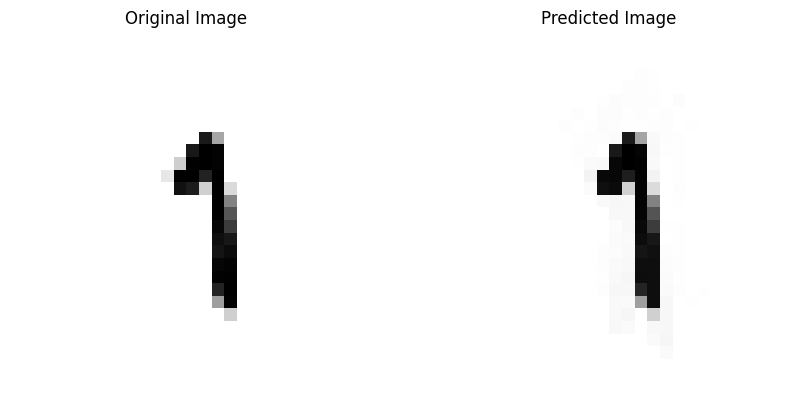

1/1 [==============================] - 0s 12ms/step
Pixel Accuracy for label '107.png': 99.44%


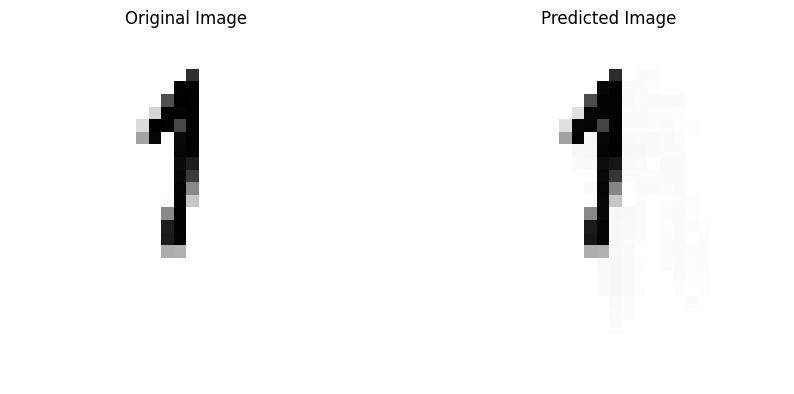

1/1 [==============================] - 0s 11ms/step
Pixel Accuracy for label '100.png': 99.52%


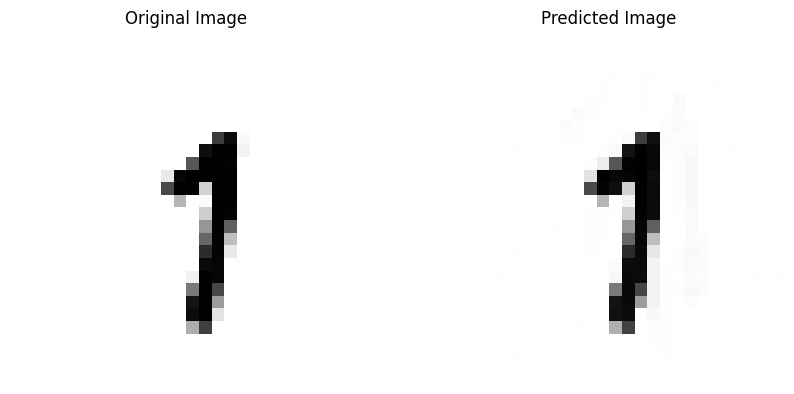

1/1 [==============================] - 0s 12ms/step
Pixel Accuracy for label '108.png': 99.67%


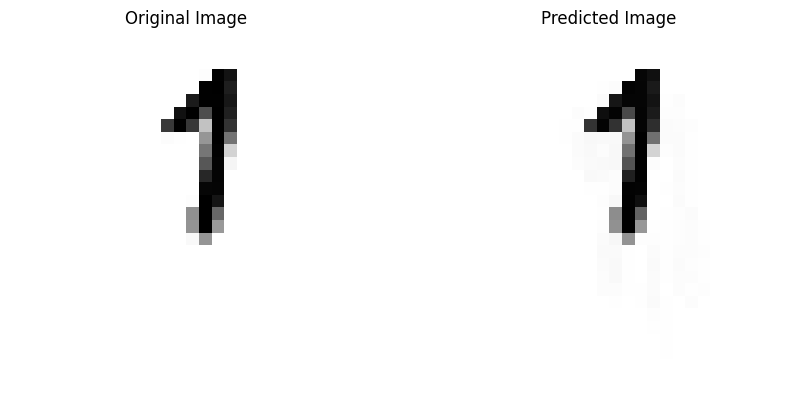

1/1 [==============================] - 0s 11ms/step
Pixel Accuracy for label '102.png': 99.50%


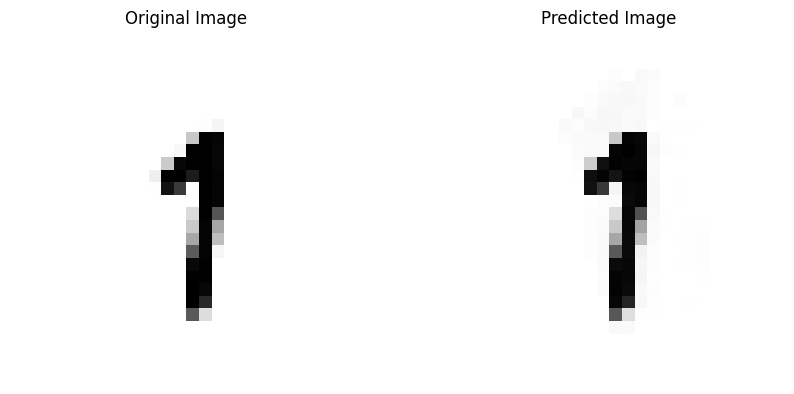

1/1 [==============================] - 0s 11ms/step
Pixel Accuracy for label '105.png': 99.66%


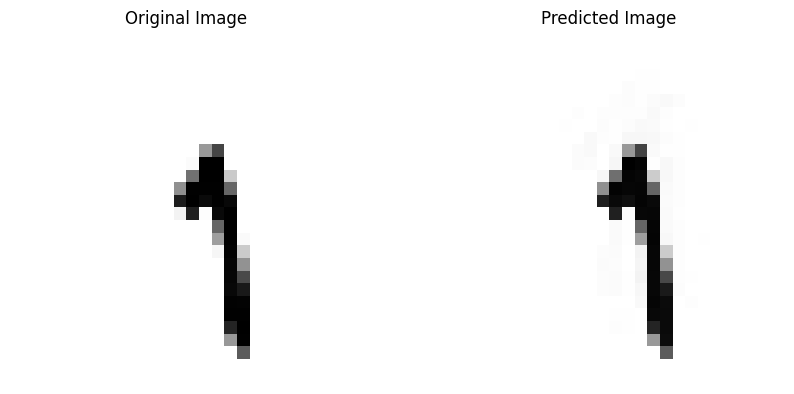

1/1 [==============================] - 0s 10ms/step
Pixel Accuracy for label '106.png': 99.64%


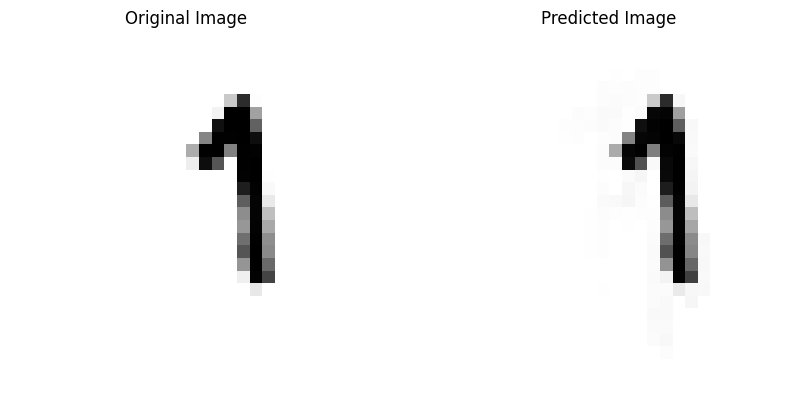

1/1 [==============================] - 0s 11ms/step
Pixel Accuracy for label '104.png': 99.40%


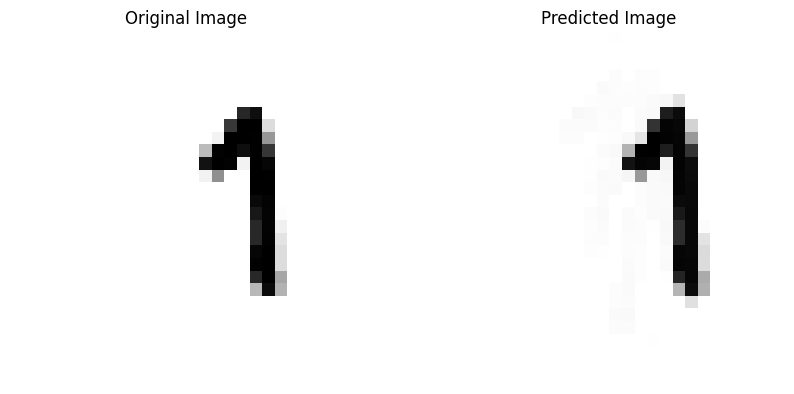

1/1 [==============================] - 0s 10ms/step
Pixel Accuracy for label '109.png': 99.57%


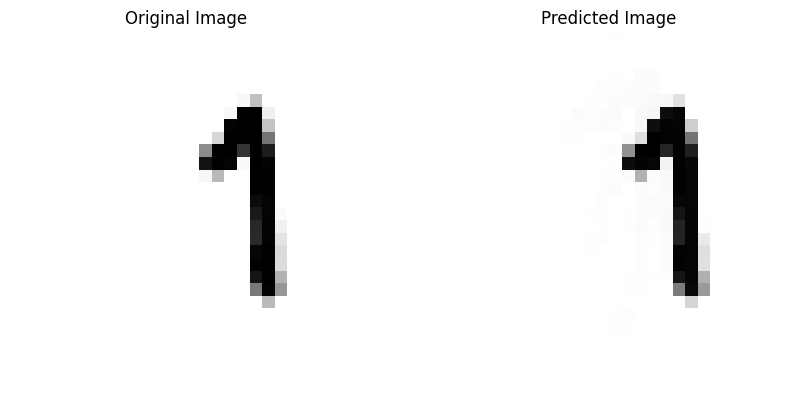

1/1 [==============================] - 0s 11ms/step
Pixel Accuracy for label '101.png': 99.51%


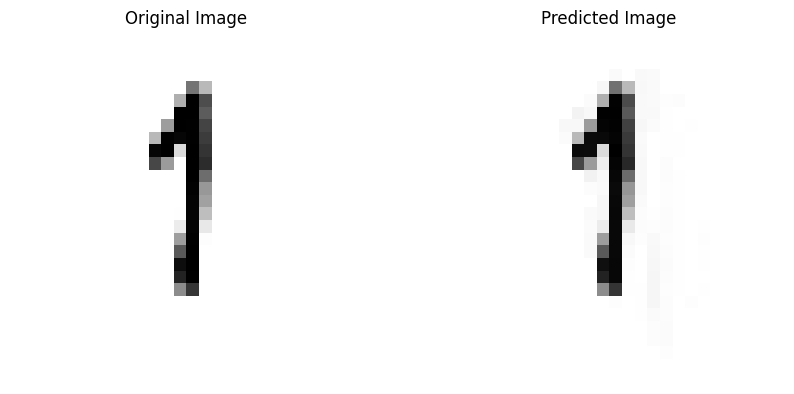


Average Pixel Accuracy over all above images: 99.55%


In [47]:
def pixel_accuracy(original, predicted):
    """
    Calculate pixel accuracy based on the mean absolute error between the original and predicted images.

    Parameters:
    original (np.array): The original image array (shape: height x width).
    predicted (np.array): The predicted image array (shape: height x width).

    Returns:
    float: The pixel accuracy as a percentage.
    """
    original = np.array(original)
    predicted = np.array(predicted)
    
    # Check if the shapes match
    if original.shape != predicted.shape:
        raise ValueError("Original and predicted images must have the same shape.")
    
    # Calculate the mean absolute error
    mae = np.mean(np.abs(original - predicted))

    # Convert MAE to a percentage accuracy (assuming pixel values are in [0, 255])
    max_mae = 255
    accuracy = 100 * (1 - (mae / max_mae))  # Normalize accuracy to be between 0 and 100

    return accuracy  # Return as percentage

# Function to get the original image data from the DataFrame
def get_original_image_from_df(label, df):
    # Locate the row in the DataFrame that matches the label
    row = df[df['label'] == label]
    if not row.empty:
        return row['image_data'].values[0]  # Get the image data
    else:
        print("Label not found in DataFrame.")
        return None

# List to hold pixel accuracy values for all predictions
all_accuracies = []

# Make a prediction
# labels_to_predict = df['label'].values
labels_to_predict = random.sample(list(df['label'].values), 10)

for label in labels_to_predict:
    encoded_label = onehot_encoder.transform([[label_encoder.transform([label])[0]]])
    predicted_image = model.predict(encoded_label)

    # Reshape the predicted image and unnormalize it (convert back to 0-255 range)
    predicted_image = predicted_image.reshape((28, 28))
    predicted_image = predicted_image * 255.0  # Unnormalize the predicted image

    # Get the original image from the DataFrame
    original_image = get_original_image_from_df(label, df)

    # Check if original image is not None
    if original_image is not None:
        # Calculate pixel accuracy
        accuracy = pixel_accuracy(original_image, predicted_image)
        all_accuracies.append(accuracy)
        print(f"Pixel Accuracy for label '{label}': {accuracy:.2f}%")

        # Set up the plot
        plt.figure(figsize=(10, 5))

        # Plot original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')  # Hide axis

        # Plot predicted image
        plt.subplot(1, 2, 2)
        plt.imshow(predicted_image, cmap='gray')
        plt.title('Predicted Image')
        plt.axis('off')  # Hide axis

        plt.show()

# Calculate and print the average pixel accuracy
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Pixel Accuracy over all above images: {average_accuracy:.2f}%")

In [48]:
# List to hold pixel accuracy values for all predictions
all_accuracies = []

# Encode all labels in the DataFrame
encoded_labels = onehot_encoder.transform([[label_encoder.transform([label])[0]] for label in df['label'].values])

# Make predictions for all encoded labels at once
predicted_images = model.predict(encoded_labels)

# Loop over all predicted images and corresponding original images
for i, label in enumerate(df['label'].values):
    predicted_image = predicted_images[i].reshape((28, 28))  # Reshape the predicted image
    predicted_image = predicted_image * 255.0  # Unnormalize the predicted image

    # Get the original image from the DataFrame
    original_image = get_original_image_from_df(label, df)

    # Check if original image is not None
    if original_image is not None:
        # Calculate pixel accuracy
        accuracy = pixel_accuracy(original_image, predicted_image)
        all_accuracies.append(accuracy)

# Calculate and print the average pixel accuracy
if all_accuracies:
    average_accuracy = np.mean(all_accuracies)
    print(f"\nAverage Pixel Accuracy over all images: {average_accuracy:.2f}%")
else:
    print("No valid images found for accuracy calculation.")

1/1 [==============================] - 0s 11ms/step

Average Pixel Accuracy over all images: 99.55%
